In [1]:
# fractal exponenial model implementation
# used to generate PV panel model data
# references:
# [1] https://ieeexplore.ieee.org/document/8312069
# [2] https://ieeexplore.ieee.org/document/6318199

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [3]:
stc = [1000, 25] #1000 W/m^2, 25 C
pv_param = [-0.080, 0.065, 22.1, 7.54, 125, 17.6, 7.1] #TCV, TCi, Voc, Isc, Pmax, Vop, Iop taken from table 1 from [1]

def vx_single(E, T, stc=stc, pv_param=pv_param):
    vmax = 1.03*pv_param[2]
    vmax_vmin = (1.03-0.85)*pv_param[2] #(1.03-0.85)Vmax
    ln_part = math.log((vmax-pv_param[2])/(vmax_vmin))
    exponent_part = math.exp((E/stc[0])*ln_part)
    
    vx = (E/stc[0])*pv_param[0]*(T-stc[1])+vmax-(vmax_vmin)*exponent_part
    return vx

def ix_single(E, T, stc=stc, pv_param=pv_param):
    
    ix = (E/stc[0])*(pv_param[3]+pv_param[1]*(T-stc[1]))
    return ix

def n_q(pv_param=pv_param):    
    
    nq = math.log((pv_param[3]-pv_param[6])/pv_param[3])/math.log(pv_param[5]/pv_param[2])
    return nq

def current(ix,vx,V,nq):
    if vx <= 0 or nq <= 0:
        raise ValueError("vx and nq must be greater than zero")

    else:
        i = ix-ix*((V/vx)**nq)
    return i



Text(0.5, 1.0, 'P-V Curve')

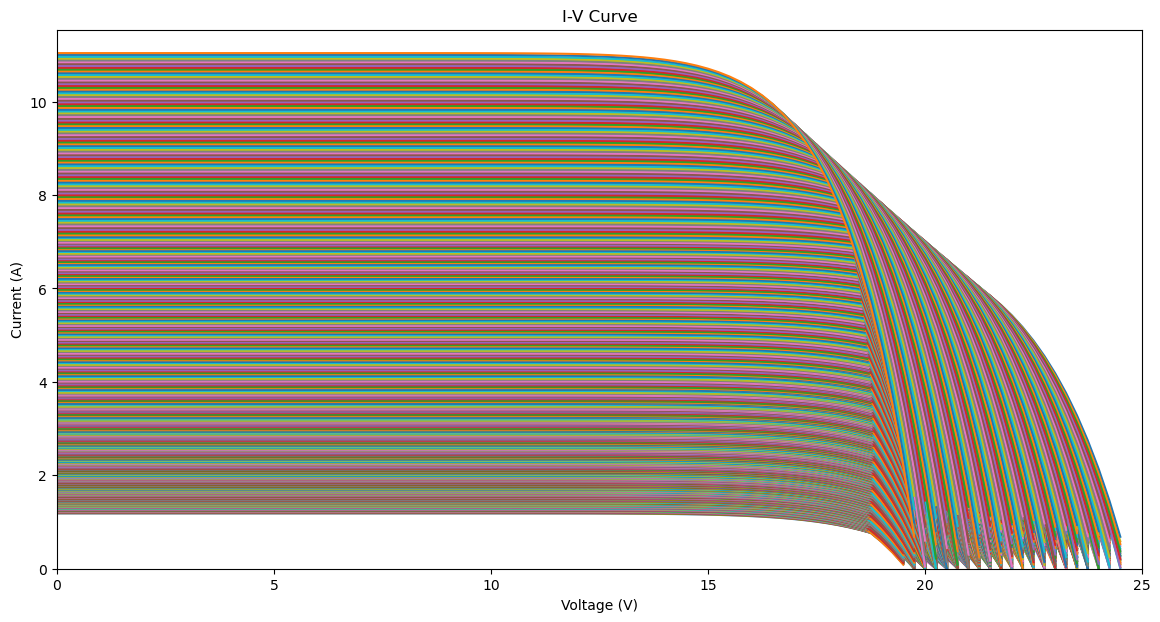

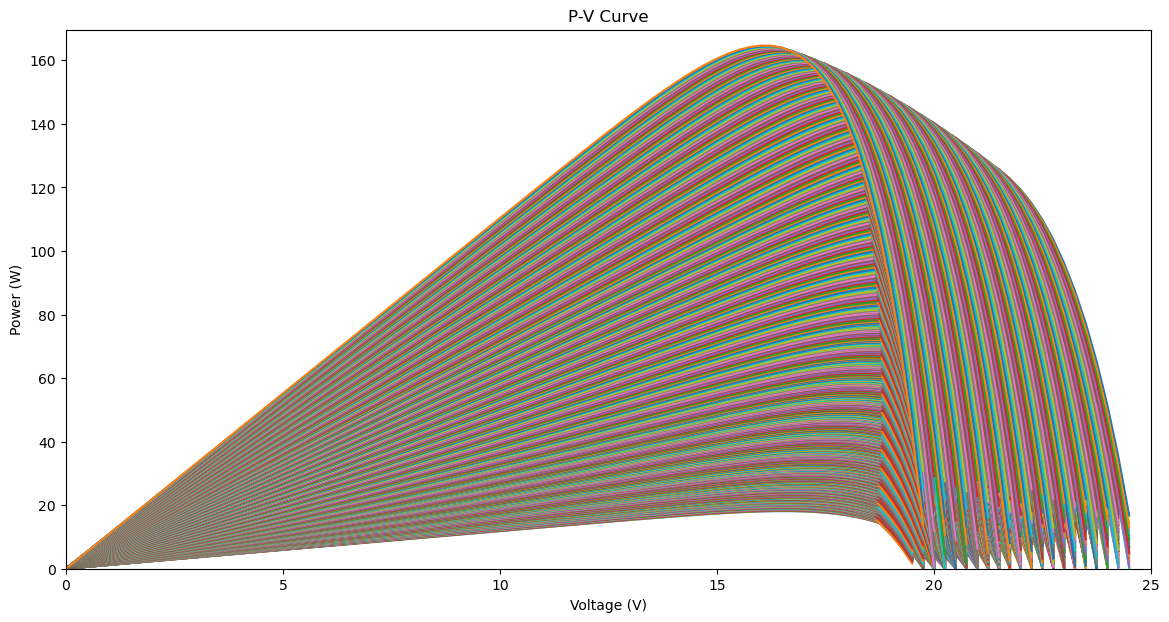

In [4]:
col_names = ['Irradiance', 'Temperature', 'Voltage', 'Current', 'Power']

irradiances = np.arange(200, 1201, 10) # Create vector of irradiance values from 200 w/m^2 to 1200 w/m^2 in 10 w/m^2 increments
temperatures = np.arange(0, 51, 0.5) # Create vector of temperature values from 0 to 51 degrees Celsius in 0.5 degree increments
voltages = np.arange(0, 1.5 * pv_param[2], 0.25)
nq = n_q() #requires no inputs as long as the default values do not change

pv_data = []
for e in irradiances:
    for t in temperatures:
        vx = vx_single(e,t)
        ix = ix_single(e,t)
        for v in voltages:
            i = current(ix,vx,v,nq)
            p = v*i
            pv_data.append([e, t, v, i, p])
            
pv_data_DF = pd.DataFrame(pv_data, columns=col_names)

# Remove negative currents and power values

negative_currents = pv_data_DF[pv_data_DF['Current']<0].index.sort_values(ascending=True).tolist()

pv_data_DF =pv_data_DF.drop(negative_currents)

# Group by irradiance and temperature

E_T_grouped = pv_data_DF.groupby(['Irradiance', 'Temperature'])

# Plot IV curve

fig, ax = plt.subplots(figsize=(14, 7))
for name, group in E_T_grouped:
    ax.plot(group['Voltage'], group['Current'])
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.set_ylim(0, pv_data_DF['Current'].max()+0.5)
ax.set_xlim(0, pv_data_DF['Voltage'].max()+0.5)
ax.set_title('I-V Curve')

# Plot PV curve

fig, ax2 = plt.subplots(figsize=(14, 7))
for name, group in E_T_grouped:
    ax2.plot(group['Voltage'], group['Power'])
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Power (W)')
ax2.set_ylim(0, pv_data_DF['Power'].max()+5)
ax2.set_xlim(0, pv_data_DF['Voltage'].max()+0.5)
ax2.set_title('P-V Curve')

In [5]:
# Generate csv file of data to local directory. 
# Change 'training_data.csv' to different directory if desired
pv_data_DF.to_csv('training_data.csv', index=False)